<a href="https://colab.research.google.com/github/SohaibAShah/FCC_ML_Python/blob/main/fcc_predict_health_costs_with_regression_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [99]:
# Import data
!wget "https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv"
dataset = pd.read_csv("insurance.csv")
dataset.tail()

--2023-10-16 07:15:16--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.4’

insurance.csv.4     100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2023-10-16 07:15:16 (4.65 MB/s) - ‘insurance.csv.4’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [100]:
#Check Missing Values
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [101]:
#Check data types
dataset.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [102]:
#Region Counts
dataset.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [103]:
dataset = dataset.join(pd.get_dummies(dataset.region, prefix='region')).drop('region', axis=1)
dataset.head()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.9,0,yes,16884.92,0,0,0,1
1,18,male,33.8,1,no,1725.55,0,0,1,0
2,28,male,33.0,3,no,4449.46,0,0,1,0
3,33,male,22.7,0,no,21984.47,0,1,0,0
4,32,male,28.9,0,no,3866.86,0,1,0,0


In [104]:
#SEX Counts
dataset.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [105]:
labels = {}

values        = dataset.sex.astype('category')
labels['sex'] = values.cat.categories
dataset['sex']     = values.cat.codes

dataset.head()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,yes,16884.92,0,0,0,1
1,18,1,33.8,1,no,1725.55,0,0,1,0
2,28,1,33.0,3,no,4449.46,0,0,1,0
3,33,1,22.7,0,no,21984.47,0,1,0,0
4,32,1,28.9,0,no,3866.86,0,1,0,0


In [106]:
#SMOKER Counts
dataset.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [107]:
values           = dataset.smoker.astype('category')
labels['smoker'] = values.cat.categories
dataset['smoker']     = values.cat.codes

dataset.head()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,1,16884.92,0,0,0,1
1,18,1,33.8,1,0,1725.55,0,0,1,0
2,28,1,33.0,3,0,4449.46,0,0,1,0
3,33,1,22.7,0,0,21984.47,0,1,0,0
4,32,1,28.9,0,0,3866.86,0,1,0,0


In [108]:
labels

{'sex': Index(['female', 'male'], dtype='object'),
 'smoker': Index(['no', 'yes'], dtype='object')}

In [109]:
dataset.drop(['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest'], axis=1, inplace=True)

In [110]:
dataset.drop(['sex', 'children'], axis=1, inplace=True)

In [111]:
# SPLIT The DATA
#shuffle the rows, just in case
dataset = dataset.sample(frac=1)

In [112]:
size          = int(len(dataset) * .2)
train_dataset = dataset[:-size] #80%
test_dataset  = dataset[-size:] #20%

print(len(dataset), len(train_dataset), len(test_dataset))

1338 1071 267


In [113]:
#Drop the Expenses Column from the dataset
train_labels  = train_dataset['expenses']
train_dataset = train_dataset.drop('expenses', axis=1)

In [114]:
test_labels   = test_dataset['expenses']
test_dataset  = test_dataset.drop('expenses', axis=1)

In [115]:
#Build the MODEL
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(len(train_dataset.keys()),)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(0.05),
    loss='mse',
    metrics=['mae', 'mse']
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Bat  (None, 3)                 12        
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 64)                256       
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4493 (17.55 KB)
Trainable params: 4487 (17.53 KB)
Non-trainable params: 6 (24.00 Byte)
_________________________________________________________________


In [116]:
r = model.fit(train_dataset, train_labels, epochs=500, verbose=0)

In [117]:
res = model.evaluate(test_dataset, test_labels, verbose=2)
print(res)

9/9 - 0s - loss: 18992980.0000 - mae: 2679.5254 - mse: 18992980.0000 - 176ms/epoch - 20ms/step
[18992980.0, 2679.525390625, 18992980.0]


9/9 - 0s - loss: 18992980.0000 - mae: 2679.5254 - mse: 18992980.0000 - 37ms/epoch - 4ms/step
Testing set Mean Abs Error: 2679.53 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 2ms/step


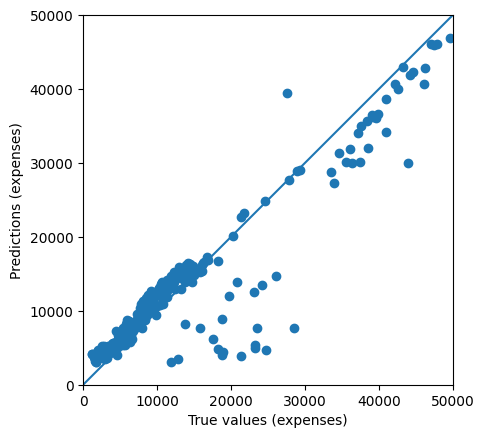

In [118]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
